# Calculate Text-Similarities by Doc2Vec Model
In this step, we hope to use the available data to train a pretty good Doc2Vec model, and then we the model to make a vector presentation for every summary of papers. we could ,therefore, use the vectors to calculate score of similarities.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
path="/content/drive/My Drive/Research/Data/"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive/


['english.txt',
 '2019_2020_all_data_final.csv',
 '2014_abs',
 '2015_abs',
 '2016_abs',
 '2017_abs',
 '2018_abs',
 'My_Process',
 'all_data_statistic.csv',
 'top_category_details.csv',
 'top5_statistic_months.csv',
 'top5_statistics_col_1.csv',
 'cs_summary',
 'My_result']

In [ ]:
from gensim.test.utils import datapath
import gensim
from gensim.corpora.dictionary import Dictionary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 读文件里面的数据转化为二维列表
def read_list(file_path):
    file1 = open(file_path, "r")
    list_row =file1.readlines()
    list_source = []
    for i in range(len(list_row)):
        column_list = list_row[i].strip().split("\t")  # 每一行split后是一个列表
        list_source.append(column_list)                # 在末尾追加到list_source
    for i in range(len(list_source)):  # 行数
        for j in range(len(list_source[i])):  # 列数
            list_source[i][j]=list_source[i][j]
    file1.close()
    return list_source


# 加载数据的函数
def read_summary(file_path):
  text = pd.read_csv(file_path,usecols=[3],encoding='ISO-8859-1',header=None,names=['summary'])

  # pd --> list
  data_list = []
  for index in range(1,len(text['summary'])):
     row_info = text.loc[index]
     summary = row_info[0]
     data_list.append(summary)
  return data_list

In [ ]:

data_lemmatized = read_list(path+'My_Process/Lemmatize_data_14to20.txt')

data=[]
index=0
for doc in data_lemmatized:
 #doc = data_lemmatized[num]
 value = gensim.models.doc2vec.TaggedDocument(doc, [index])
 data.append(value)
 index+=1

In [ ]:
# 训练模型

model_word2doc = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=100)

model_word2doc.build_vocab(data)

model_word2doc.train(data, total_examples=model_word2doc.corpus_count, epochs=model_word2doc.epochs)

In [ ]:
# 模型保存
#model_word2doc.save(path+'My_result/doc2vec/doc2vec_t50')

#模型加载
model_word2doc = gensim.models.doc2vec.Doc2Vec.load(path+'My_result/doc2vec/doc2vec_t50')

In [ ]:
# 构建相似矩阵
dimension = 50
similarity_matric = []

for doc in data_lemmatized:
  vector = model_word2doc.infer_vector(doc)
  similarity_matric.append(vector)

NameError: ignored

In [ ]:
#保存计算数据
similarity_matric = np.array(similarity_matric)
np.save(path+'My_result/doc2vec/vector_by_doc2vec.npy',similarity_matric)

8093085


In [ ]:
# 加载已有数据
similarity_data = np.load(path+'My_result/doc2vec/vector_by_doc2vec.npy')
#similarity_data =similarity_data.tolist()

In [ ]:
#加载index_year  （包含data里的数据划分节点数）
index_year_ = np.load(path+'My_Process/index_year.npy')
index_year_=index_year_.tolist()
index_year_[12]

10802

In [ ]:
similarity_data[0,:2]

array([-1.6906971 ,  0.51356953], dtype=float32)

In [ ]:
def similarity_processor(sim_matrix,process_number,begin_months,last_months,interaction):
 # 计算三个重要节点
 process_number = process_number
 begin_months = begin_months
 last_months = last_months
 interaction = interaction

 start_index =index_year_[len(index_year_)-process_number-last_months-begin_months-interaction]
 end_of_begin = index_year_[len(index_year_)-process_number-last_months-interaction]-1
 start_of_last = index_year_[len(index_year_)-process_number-last_months]
 end_index = index_year_[len(index_year_)-process_number]-1
 print('原index: ',start_index,end_index)

 sim_matrix_sub = sim_matrix[start_index:end_index]   #由于研究的是连续的13个月，所以可以这么取数据

 start_of_last = start_of_last - start_index
 end_of_begin = end_of_begin - start_index
 end_index = end_index - start_index-(start_of_last - end_of_begin) 
 start_index = 0
 print('现index: ',start_of_last,end_index-end_of_begin)

 # 向量normalization,为下边求角度做准备
 array_result_norm = []
 for vector in sim_matrix_sub:
   if np.linalg.norm(vector) == 0:
    array_result_norm.append(vector)
   else:
    array_result_norm.append(vector/np.linalg.norm(vector))
 array_result_norm = np.array(array_result_norm)
 
 # 计算相似矩阵-->相似度
 begin_matrix = array_result_norm[:start_of_last,:]  # 算法一，一年
 #begin_matrix = sim_matrix[0:start_of_last,:]        # 算法二，两年
 last_matrix = array_result_norm[start_of_last:,:]
 last_matrix = last_matrix.T

 similarity_matrix = np.dot(begin_matrix,last_matrix)
 print('complete similarity matrix')

 #计算相似度,通过矩阵运算直接计算,不在调用API
 line_number = len(similarity_matrix)
 column_number = len(similarity_matrix[0])
 vecor_1 = np.ones([1,line_number])
 vector_2 = np.ones([column_number,1])
 total_number = line_number*column_number

 similarity_value = np.dot(vecor_1,np.dot(similarity_matrix,vector_2))
 similarity_value = similarity_value[0,0] / total_number
 print('complete similarity value') 
 return similarity_value


In [ ]:
####### 计算相似度########

final_result = []


for number in range(1,49):
  #准备参数
  last_months = 1
  begin_months = 12
  interaction = 0
  process_number = number

  #调函数，计算相似的
  print('process ',number,' begin')
  similarity = similarity_processor(similarity_data,process_number,begin_months,last_months,interaction)
  print('process number ',number,' simililarity:',similarity)
  final_result.append(similarity)
  print('similarity data is: ',final_result )
  print()
  print()


process  1  begin
原index:  117190 165164
现index:  47833 141
complete similarity matrix
complete similarity value
process number  1  simililarity: 0.08231342915623514
similarity data is:  [0.08231342915623514]


process  2  begin
原index:  114337 165022
现index:  45853 4832
complete similarity matrix
complete similarity value
process number  2  simililarity: 0.08138088769042842
similarity data is:  [0.08231342915623514, 0.08138088769042842]


process  3  begin
原index:  111373 160189
现index:  42952 5864
complete similarity matrix
complete similarity value
process number  3  simililarity: 0.08134701765762929
similarity data is:  [0.08231342915623514, 0.08138088769042842, 0.08134701765762929]


process  4  begin
原index:  108241 154324
现index:  42003 4080
complete similarity matrix
complete similarity value
process number  4  simililarity: 0.0809044624697949
similarity data is:  [0.08231342915623514, 0.08138088769042842, 0.08134701765762929, 0.0809044624697949]


process  5  begin
原index:  10

In [ ]:
# 保存模型
np.save(path+'My_result/doc2vec/Final_Similarity_Doc2Vec_Summary.npy',final_result)

Text(0, 0.5, 'Similarity')

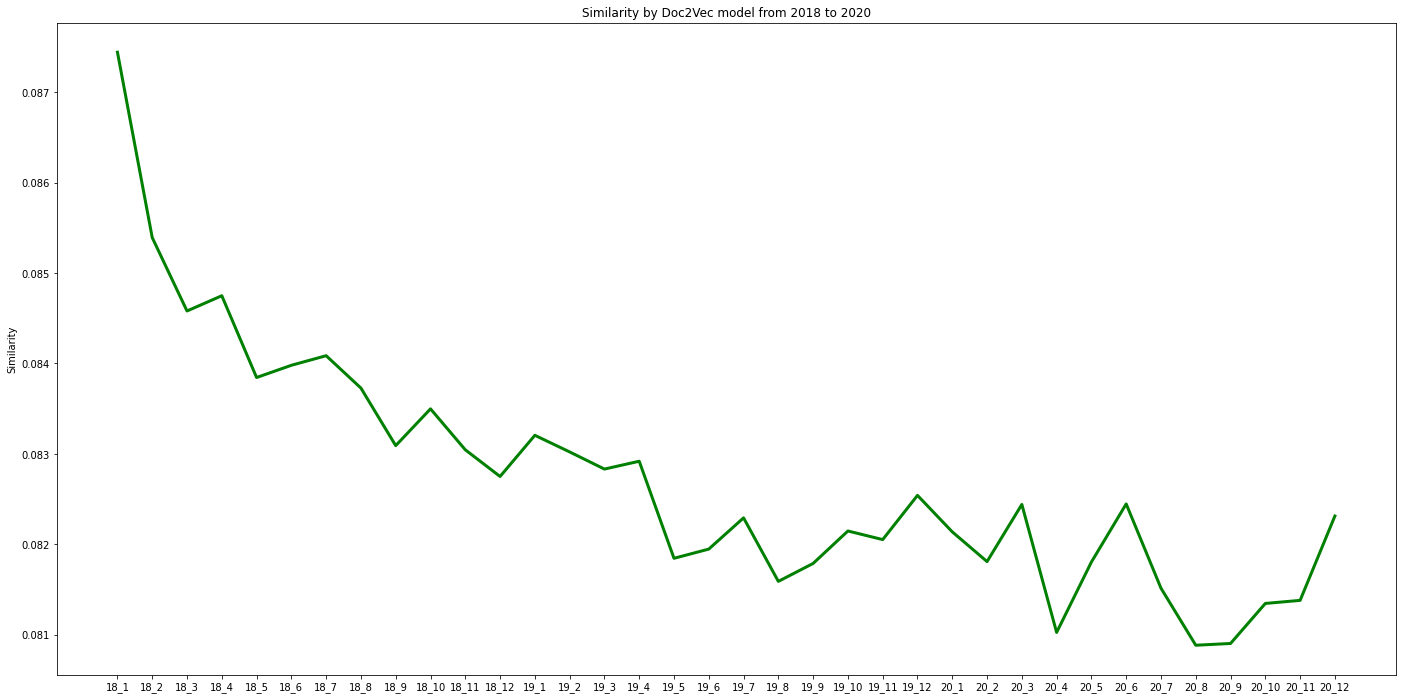

In [ ]:
###画图
# 制作x轴
years = ['18','19','20']
months=['1','2','3','4','5','6','7','8','9','10','11','12']
x_line =[]

for year in years:
  for month in months:
    x_word = year+'_'+month
    x_line.append(x_word)

# 算法一 ：  一年
sim_doc2vec = np.load(path+'My_result/doc2vec/Final_Similarity_Doc2Vec_Summary.npy')
sim_doc2vec = sim_doc2vec.tolist()
sim_doc2vec_in = sim_doc2vec[::-1]


#画图
fig, ax = plt.subplots(figsize=(24, 12))
x = x_line
y = sim_doc2vec_in[12:48]
ax.plot(x,y, linewidth=3,color='green')
ax.set_title('Similarity by Doc2Vec model from 2018 to 2020')
ax.set_ylabel('Similarity')